### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Prep

In [2]:
COMP_PATH = "/kaggle/input/icr-identify-age-related-conditions"
train = pd.read_csv(f"{COMP_PATH}/train.csv")
test = pd.read_csv(f"{COMP_PATH}/test.csv")
sample_submission = pd.read_csv(f"{COMP_PATH}/sample_submission.csv")
greeks = pd.read_csv(f"{COMP_PATH}/greeks.csv")

In [3]:
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
cols = train.columns
feat_cols = cols[1:]
num_cols = train.select_dtypes(include=['float64']).columns
print("No of Columns:", len(cols))

No of Columns: 58


### Metric

In [5]:
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2

def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

In [6]:
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

### Feature Engineering

In [7]:
# Label encoding
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].map({'A': 0, 'B': 1})

In [8]:
scaler = StandardScaler()
df, test_df = train.copy(), test.copy()
new_num_cols = train.select_dtypes(include=['float64']).columns
df[new_num_cols] = scaler.fit_transform(train[new_num_cols])
test_df[new_num_cols] = scaler.transform(test[new_num_cols])
df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,...,0.162821,-0.035806,-0.250437,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814049,1
1,007255e47698,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,...,-0.457925,-0.060566,0.113640,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304860,0
2,013f2bd269f5,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,...,0.198663,-0.051023,0.597343,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.806623,0
3,043ac50845d5,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,...,0.060364,-0.060566,-0.104806,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.810609,0
4,044fb8a146ec,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,...,0.237302,0.896815,-0.229632,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.816349,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,-0.699975,-0.161828,0.040232,-0.422762,0.275215,-0.802577,0.040875,-0.464891,-0.080610,...,-0.457925,-0.045332,-0.271241,-1.177680,0.593022,-0.340465,-0.694915,0.513497,1.304860,0
613,fd895603f071,-0.088253,0.852755,-0.261669,0.108831,0.556117,0.170319,-0.082686,0.473063,-0.065661,...,0.417655,-0.045702,0.004417,1.519617,2.535523,-0.599582,-0.186764,2.048314,-0.811625,0
614,fd8ef6377f76,-0.106514,-0.453742,0.090140,0.235206,-0.011673,0.990330,-0.083417,1.113828,-0.104787,...,-0.457925,-0.060566,-0.271241,-0.076400,-0.019561,-0.424307,-0.540129,1.903449,1.304860,0
615,fe1942975e40,-0.243466,-0.973904,-0.261669,-0.219353,-0.189295,0.955584,-0.083417,-0.699741,-0.104787,...,0.333481,-0.054771,0.191657,0.387591,-0.410260,-0.657500,-0.646592,-0.370599,-0.807817,0


## K-Means

In [9]:
# エルボー法によるK-meansの可視化関数の定義
def plot_kmeans(input_data, num_cluster):
    dist_list =[]
    for i in range(1,num_cluster):
        kmeans= KMeans(n_clusters=i, init='random', random_state=0)
        kmeans.fit(input_data)
        dist_list.append(kmeans.inertia_)
    
    # グラフを表示
    plt.plot(range(1,num_cluster), dist_list,marker='+')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')

In [10]:
# K-Meansの可視化の上限設定
NUM_CLUSTER = 50

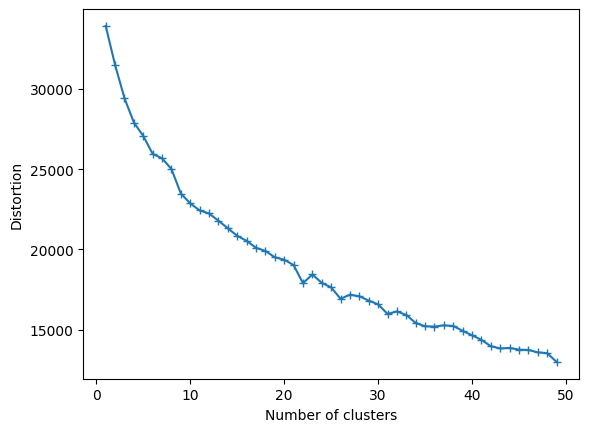

In [11]:
# エルボー法によるK-Meansの実施
plot_kmeans(df.drop(["Id", "EJ", "Class"], axis=1), NUM_CLUSTER)

In [12]:
# クラスを含めない状態でクラスター数7でラベリング
num_cluster = 5

# kmeansクラスをインスタンス化
kmeans = KMeans(init='random', n_clusters=num_cluster, random_state=0)

# train dataでトレーニング
kmeans.fit(df.drop(["Id", "EJ", "Class"], axis=1))

# predict
km_label_train =pd.Series(kmeans.labels_, name='cluster_number_{}'.format(num_cluster))
km_label_test =pd.Series(kmeans.predict(test_df.drop(["Id", "EJ"], axis=1)), name='cluster_number_{}'.format(num_cluster))

In [13]:
# 本番データに結合
df["cluster_label"] = km_label_train
test_df["cluster_label"] = km_label_test

In [14]:
df.groupby(["cluster_label"])["Class"].sum()

cluster_label
0     0
1    30
2    18
3    11
4    49
Name: Class, dtype: int64

## aggrigationの実装

In [15]:
test_df["cluster_label"]

0    4
1    4
2    4
3    4
4    4
Name: cluster_label, dtype: int32

In [16]:
agg_cols = ['min', 'max', 'mean', 'std']
cat_cols = ["cluster_label"]

for col in cat_cols:
    grp_df = df.groupby(col)[num_cols].agg(agg_cols)
    grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
    df = df.merge(grp_df, on=col, how='left')
    test_df = test_df.merge(grp_df, on=col, how='left')

## 特徴選択

In [17]:
# thresholdを超える相関を持つカラムの削除
threshold = 0.8
print(len(df.columns))

feat_corr = set()
corr_matrix = df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feat_name = corr_matrix.columns[i]
            feat_corr.add(feat_name)

print(len(set(feat_corr)))

df.drop(labels=feat_corr, axis='columns', inplace=True)
test_df.drop(labels=feat_corr, axis='columns', inplace=True)

print(len(df.columns))

279
220
59


### CV

In [18]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
df['fold'] = -1

for fold, (train_idx, test_idx) in enumerate(kf.split(df, greeks['Alpha'])):
    df.loc[test_idx, 'fold'] = fold

df.groupby('fold')["Class"].value_counts()

fold  Class
0     0        101
      1         23
1     0        102
      1         22
2     0        102
      1         21
3     0        102
      1         21
4     0        102
      1         21
Name: Class, dtype: int64

### Training

In [19]:
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []
importance = None

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000,
            eval_metric=lgb_metric)
    
    y_pred = lgb.predict_proba(X_valid)
    preds_test  = lgb.predict_proba(test_df.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    # feature importanceの算出
    if importance is None:
        importance = pd.DataFrame(lgb.feature_importances_, index=X_train.columns, columns=['fold{}_importance'.format(fold)])
    else:
        importance['fold{}_importance'.format(fold)] = lgb.feature_importances_

    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print(np.mean(balanced_log_losses), np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.221, balanced los loss: 0.158
Fold: 1, log loss: 0.258, balanced los loss: 0.164
[1000]	valid_0's balanced_log_loss: 0.0332561
Fold: 2, log loss: 0.06, balanced los loss: 0.032
Fold: 3, log loss: 0.21, balanced los loss: 0.107
Fold: 4, log loss: 0.244, balanced los loss: 0.151

Log Loss
[0.22125153439506276, 0.2581022695793122, 0.059865788112788025, 0.21022557773675896, 0.2436320227117622]
0.19861543850713684 0.07136361759187136

Balanced Log Loss
[0.15837058963354286, 0.16369856598557395, 0.032106122452403844, 0.10720049908928571, 0.1508648563882301]
0.12244812670980729 0.049383601508732056

Weights
[6.314303699404805, 6.1087890048354225, 31.14670734475842, 9.32831477927276, 6.628448957168902]


## 特徴選択

In [20]:
fold_num = 5
for i in range(fold_num):
    if i == 0:
        importance["sum_imp"] = importance["fold{}_importance".format(i)]
    else:
        importance["sum_imp"] += importance["fold{}_importance".format(i)]

In [21]:
# 上位X個のカラムを使用
use_col_rank = 30

In [22]:
importance.sort_values('sum_imp', ascending=False, inplace=True)
importance.head()

,fold0_importance,fold1_importance,fold2_importance,fold3_importance,fold4_importance,sum_imp
DU,48,42,339,58,80,567
BQ,42,42,207,44,65,400
FL,54,37,183,56,37,367
AB,36,39,184,43,52,354
CR,38,36,134,44,48,300


In [23]:
len(importance.iloc[:use_col_rank])

30

In [24]:
selected_cols = importance.iloc[:use_col_rank].index.tolist()

In [25]:
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []
importance = None

selected_df = df[selected_cols]
selected_df["fold"] = df["fold"]
selected_df["Class"] = df["Class"]
selected_df["Id"] = df["Id"]
selected_test_df = test_df[selected_cols]
selected_test_df["Id"] = test_df["Id"]

for fold in range(5):
    train_df = selected_df[df['fold'] != fold]
    valid_df = selected_df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000,
            eval_metric=lgb_metric)
    
    y_pred = lgb.predict_proba(X_valid)
    preds_test  = lgb.predict_proba(selected_test_df.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    # feature importanceの算出
    if importance is None:
        importance = pd.DataFrame(lgb.feature_importances_, index=X_train.columns, columns=['fold{}_importance'.format(fold)])
    else:
        importance['fold{}_importance'.format(fold)] = lgb.feature_importances_

    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print(np.mean(balanced_log_losses), np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.26, balanced los loss: 0.16
Fold: 1, log loss: 0.182, balanced los loss: 0.127
Fold: 2, log loss: 0.037, balanced los loss: 0.023
Fold: 3, log loss: 0.175, balanced los loss: 0.082
Fold: 4, log loss: 0.189, balanced los loss: 0.122

Log Loss
[0.2596507350735668, 0.1817958581599444, 0.036953423497550535, 0.17510843577776983, 0.1894810434306606]
0.16859789918789844 0.07248940036141688

Balanced Log Loss
[0.1597979109765036, 0.12702277741049614, 0.022513780977008332, 0.08167574718713433, 0.12197629754364979]
0.10259730281895843 0.04710656170815293

Weights
[6.257904085786443, 7.872603798988952, 44.41723942420984, 12.243536599779295, 8.198314099853254]


## submission

In [26]:
test_preds = np.zeros((test_df.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[0.91568513, 0.08431487],
       [0.91568513, 0.08431487],
       [0.91568513, 0.08431487],
       [0.91568513, 0.08431487],
       [0.91568513, 0.08431487]])

In [27]:
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ['Id', 'class_0', 'class_1']
final_valid_predictions.to_csv(r"oof.csv", index=False)

test_dict = {}
test_dict.update(dict(zip(test.Id.values.tolist(), test_preds)))
submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
submission.columns = ['Id', 'class_0', 'class_1']                       

submission.to_csv(r"submission.csv", index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.915685,0.084315
1,010ebe33f668,0.915685,0.084315
2,02fa521e1838,0.915685,0.084315
3,040e15f562a2,0.915685,0.084315
4,046e85c7cc7f,0.915685,0.084315
